# Import libraries

In [85]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import random
from tqdm import tqdm
import pandas as pd
import string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import *
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Load the csv



In [86]:
train_data_path = '/content/drive/My Drive/Colab Notebooks/24_train_1.csv'
test_data_path = '/content/drive/My Drive/Colab Notebooks/news-test.csv'

# Load data
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)
print(train_data.head())
print(test_data.head())

   ArticleId                                               Text  Category
0       1429  sfa awaits report over mikoliunas the scottish...     sport
1       1896  parmalat to return to stockmarket parmalat  th...  business
2       1633  edu blasts arsenal arsenal s brazilian midfiel...     sport
3       2178  henman decides to quit davis cup tim henman ha...     sport
4        194  french suitor holds lse meeting european stock...  business
   ArticleId                                               Text
0       1018  qpr keeper day heads for preston queens park r...
1       1319  software watching while you work software that...
2       1138  d arcy injury adds to ireland woe gordon d arc...
3        459  india s reliance family feud heats up the ongo...
4       1020  boro suffer morrison injury blow middlesbrough...


# Section 1: Preprocess Data

In [87]:
stemmer = PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def preprocess_text(text):
    lowers = text.lower()
    no_punctuation = lowers.translate(remove_punctuation_map)
    tokens = nltk.word_tokenize(no_punctuation)
    filtered = [w for w in tokens if not w in stopwords.words("english")]
    stemmed = [stemmer.stem(item) for item in filtered]
    return " ".join(stemmed)

# Apply preprocessing to the entire training and testing dataset
train_data['Processed_Text'] = train_data['Text'].apply(preprocess_text)
test_data['Processed_Text'] = test_data['Text'].apply(preprocess_text)
# Display the first few rows of the processed training and testing data
print(train_data[['ArticleId', 'Processed_Text', 'Category']].head())
print(test_data[['ArticleId', 'Processed_Text']].head())


   ArticleId                                     Processed_Text  Category
0       1429  sfa await report mikoliuna scottish footbal as...     sport
1       1896  parmalat return stockmarket parmalat italian d...  business
2       1633  edu blast arsen arsen brazilian midfield edu h...     sport
3       2178  henman decid quit davi cup tim henman retir gr...     sport
4        194  french suitor hold lse meet european stock mar...  business
   ArticleId                                     Processed_Text
0       1018  qpr keeper day head preston queen park ranger ...
1       1319  softwar watch work softwar monitor everi keyst...
2       1138  arci injuri add ireland woe gordon arci rule i...
3        459  india relianc famili feud heat ongo public spa...
4       1020  boro suffer morrison injuri blow middlesbrough...


# Section 2 : Decision tree model
**Part 2.1**: Splitting the Data 80-20

In [88]:

# Split the data into features and target
X = train_data['Processed_Text']
y = train_data['Category']
# Convert the text to a matrix of token counts
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(X)

dt_classifier = DecisionTreeClassifier()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

dt_classifier.fit(X_train, y_train)

y_pred_val = dt_classifier.predict(X_val)

accuracy = accuracy_score(y_val, y_pred_val)
print(f"Validation Accuracy of the Decision Tree model is: {accuracy}")

Validation Accuracy of the Decision Tree model is: 0.83


**Part 2.1** : Decision Tree Evaluation with gini, entropy and then plotting the bar chart

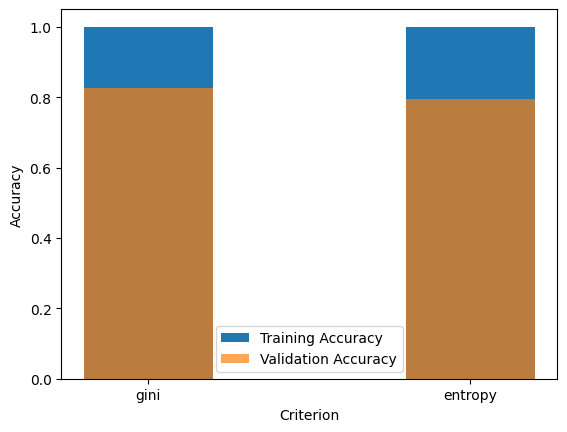

In [89]:


# Separate input features and target
X = train_data['Processed_Text']
y = train_data['Category']
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# We need to convert text data into numerical data for decision tree using TfidfVectorizer

vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_vectorized, y_encoded, test_size=0.2)

# Decision Tree with different criterion
criterions = ['gini', 'entropy']
train_accuracies = []
val_accuracies = []

for criterion in criterions:
    tree = DecisionTreeClassifier(criterion=criterion)
    tree.fit(X_train, y_train)
    y_train_pred = tree.predict(X_train)
    y_val_pred = tree.predict(X_val)

    train_accuracies.append(accuracy_score(y_train, y_train_pred))
    val_accuracies.append(accuracy_score(y_val, y_val_pred))

# Plot bar chart
plt.bar(criterions, train_accuracies, width=0.4, label='Training Accuracy')
plt.bar(criterions, val_accuracies, width=0.4, label='Validation Accuracy', alpha=0.7)
plt.xlabel('Criterion')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



**Part 2.2.1**: Decision Tree Evaluation with 5-fold cross-validation w.r.t min_samples_leaf

In [90]:


min_samples_leaf_values = [10, 50, 100, 150, 200]

avg_train_scores = []
avg_val_scores = []

for min_samples_leaf in min_samples_leaf_values:
    tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    # Perform 5-fold cross-validation
    scores = cross_validate(tree, X_vectorized, y_encoded, cv=5, return_train_score=True)
    avg_train_scores.append((min_samples_leaf, np.mean(scores['train_score']), np.std(scores['train_score'])))
    avg_val_scores.append((min_samples_leaf, np.mean(scores['test_score']), np.std(scores['test_score'])))

df_train_scores = pd.DataFrame(avg_train_scores, columns=['min_samples_leaf', 'training accuracy', 'training standard Deviation'])
df_val_scores = pd.DataFrame(avg_val_scores, columns=['min_samples_leaf', 'validation accuracy', 'validation standard Deviation'])

# Display the results
print("Average Training Scores:\n", df_train_scores)
print("\nAverage Validation Scores:\n", df_val_scores)


Average Training Scores:
    min_samples_leaf  training accuracy  training standard Deviation
0                10            0.86950                     0.007053
1                50            0.72275                     0.008116
2               100            0.57650                     0.051844
3               150            0.48700                     0.023856
4               200            0.37950                     0.014111

Average Validation Scores:
    min_samples_leaf  validation accuracy  validation standard Deviation
0                10                0.782                       0.048229
1                50                0.693                       0.034147
2               100                0.516                       0.038131
3               150                0.483                       0.014000
4               200                0.372                       0.032955


**Part 2.2.2**: Decision Tree Evaluation with 5-fold cross-validation w.r.t min_samples_leaf - Line chart

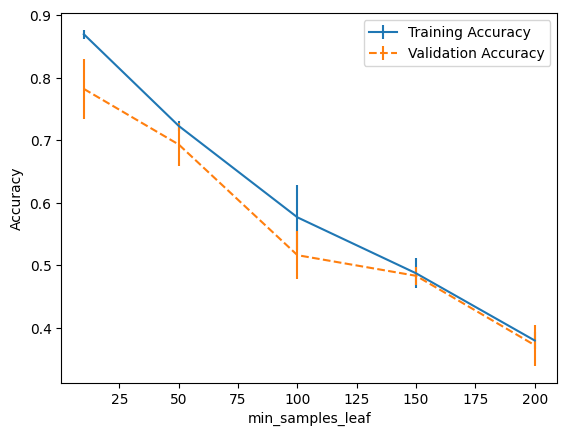

In [91]:
# Plotting line chart
plt.errorbar(df_train_scores['min_samples_leaf'], df_train_scores['training accuracy'], yerr=df_train_scores['training standard Deviation'], label='Training Accuracy')
plt.errorbar(df_val_scores['min_samples_leaf'], df_val_scores['validation accuracy'], yerr=df_val_scores['validation standard Deviation'], label='Validation Accuracy', linestyle='--')
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


**Part 2.3.1**  : Decision Tree Evaluation with 5-fold cross-validation w.r.t max_features

In [92]:
# Possible max_features values
max_features_values = [ 'sqrt', 'log2', None, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9]
avg_train_scores = []
avg_val_scores = []

for max_features in max_features_values:
    tree = DecisionTreeClassifier(max_features=max_features)
    scores = cross_validate(tree, X_vectorized, y_encoded, cv=5, return_train_score=True)

    avg_train_scores.append((max_features, np.mean(scores['train_score']), np.std(scores['train_score'])))
    avg_val_scores.append((max_features, np.mean(scores['test_score']), np.std(scores['test_score'])))

df_train_scores = pd.DataFrame(avg_train_scores, columns=['max_features', 'training accuracy', 'training standard Deviation'])
df_val_scores = pd.DataFrame(avg_val_scores, columns=['max_features', 'validation accuracy', 'validation standard Deviation'])

print("Average Training Scores:\n", df_train_scores)
print("\nAverage Validation Scores:\n", df_val_scores)




Average Training Scores:
   max_features  training accuracy  training standard Deviation
0         sqrt                1.0                          0.0
1         log2                1.0                          0.0
2         None                1.0                          0.0
3          0.2                1.0                          0.0
4          0.3                1.0                          0.0
5          0.5                1.0                          0.0
6          0.7                1.0                          0.0
7          0.8                1.0                          0.0
8          0.9                1.0                          0.0

Average Validation Scores:
   max_features  validation accuracy  validation standard Deviation
0         sqrt                0.643                       0.025807
1         log2                0.511                       0.052288
2         None                0.817                       0.036688
3          0.2                0.777            

**Part 2.3.2**  Decision Tree Evaluation with 5-fold cross-validation w.r.t max_features - Line Graph

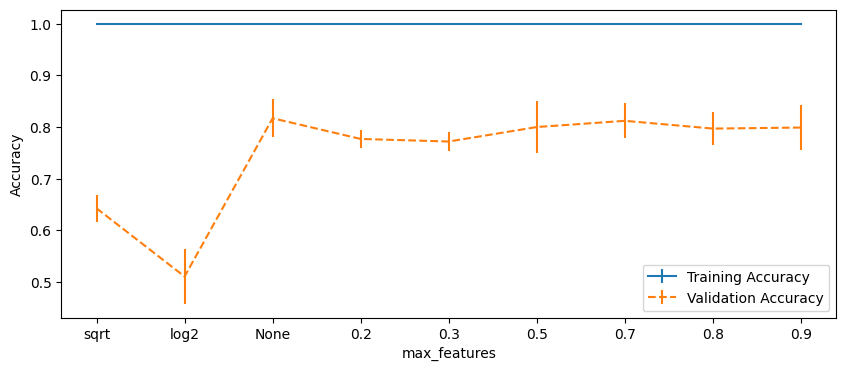

In [93]:
# Plot the line chart for max_features
plt.figure(figsize=(10, 4))
plt.errorbar([str(feat) for feat in df_train_scores['max_features']], df_train_scores['training accuracy'], yerr=df_train_scores['training standard Deviation'], label='Training Accuracy')
plt.errorbar([str(feat) for feat in df_val_scores['max_features']], df_val_scores['validation accuracy'], yerr=df_val_scores['validation standard Deviation'], label='Validation Accuracy', linestyle='--')
plt.xlabel('max_features')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Section 3 :  Random forests model


**Part 3.2.1**: Use 5-fold cross-validation to evaluate the performance w.r.t. the number of trees (n_estimators)

In [94]:
# Random Forest model with specified parameter settings
rf_model = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, random_state=42)

# Use 5-fold cross-validation to evaluate the performance w.r.t. the number of trees (n_estimators)
n_estimators_values = [50, 100, 150, 200, 250]
results_n_estimators = []

for n_estimator in n_estimators_values:
    rf_model = RandomForestClassifier(n_estimators=n_estimator, random_state=42)
    cv_results = cross_validate(rf_model, X_vectorized, y_encoded, cv=5, return_train_score=True)
    avg_train_accuracy = np.mean(cv_results['train_score'])
    avg_validation_accuracy = np.mean(cv_results['test_score'])
    train_std = np.std(cv_results['train_score'])
    val_std = np.std(cv_results['test_score'])
    results_n_estimators.append((n_estimator, avg_train_accuracy, train_std, avg_validation_accuracy, val_std))

#  convert results in a table
columns = ['n_estimators', 'avg_training_accuracy', 'training standard Deviation', 'avg_validation_accuracy', 'validation standard Deviation']
results_n_estimators_df = pd.DataFrame(results_n_estimators, columns=columns)
print("Results for different number of trees (n_estimators):")
print(results_n_estimators_df)





Results for different number of trees (n_estimators):
   n_estimators  avg_training_accuracy  training standard Deviation  \
0            50                    1.0                          0.0   
1           100                    1.0                          0.0   
2           150                    1.0                          0.0   
3           200                    1.0                          0.0   
4           250                    1.0                          0.0   

   avg_validation_accuracy  validation standard Deviation  
0                    0.936                       0.018547  
1                    0.944                       0.018000  
2                    0.948                       0.012083  
3                    0.947                       0.015684  
4                    0.951                       0.014967  


**Part 3.2.2**: Use 5-fold cross-validation to evaluate the performance w.r.t. the number of trees (n_estimators) - Line Graph

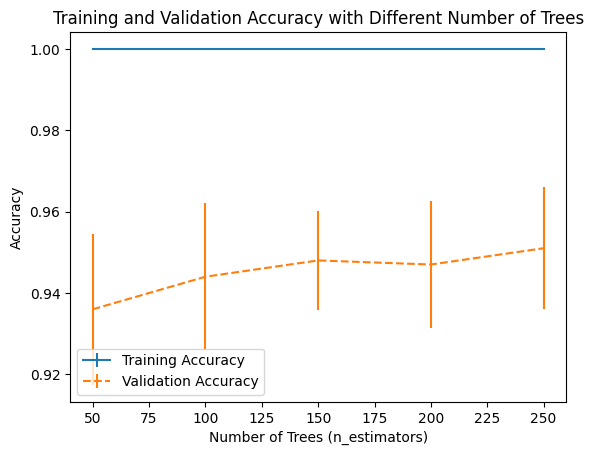

In [95]:

# Draw a line figure showing the training and validation result
plt.errorbar(results_n_estimators_df['n_estimators'], results_n_estimators_df['avg_training_accuracy'], yerr=results_n_estimators_df['training standard Deviation'], label='Training Accuracy')
plt.errorbar(results_n_estimators_df['n_estimators'], results_n_estimators_df['avg_validation_accuracy'], yerr=results_n_estimators_df['validation standard Deviation'], label='Validation Accuracy', linestyle='--')
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy with Different Number of Trees')
plt.legend()
plt.show()


**Part 3.3.1**: Use 5-fold cross-validation to evaluate the performance w.r.t. min_samples_leaf





In [96]:
# Use 5-fold cross-validation to evaluate the performance w.r.t. the minimum number of samples required to be at a leaf node (min_samples_leaf)
min_samples_leaf_values = [1, 5, 10, 20, 50]
results_min_samples_leaf = []

for min_samples_leaf in min_samples_leaf_values:
    rf_model = RandomForestClassifier(min_samples_leaf=min_samples_leaf, n_estimators=100, random_state=42)
    cv_results = cross_validate(rf_model, X_vectorized, y_encoded, cv=5, return_train_score=True)
    avg_train_accuracy = np.mean(cv_results['train_score'])
    avg_validation_accuracy = np.mean(cv_results['test_score'])
    train_std = np.std(cv_results['train_score'])
    val_std = np.std(cv_results['test_score'])
    results_min_samples_leaf.append((min_samples_leaf, avg_train_accuracy, train_std, avg_validation_accuracy, val_std))

# Convert the results in a table
columns = ['min_samples_leaf', 'avg_training_accuracy', 'training_std', 'avg_validation_accuracy', 'validation_std']
results_min_samples_leaf_df = pd.DataFrame(results_min_samples_leaf, columns=columns)
print("Results for different minimum number of samples required at a leaf node (min_samples_leaf):")
print(results_min_samples_leaf_df)



Results for different minimum number of samples required at a leaf node (min_samples_leaf):
   min_samples_leaf  avg_training_accuracy  training_std  \
0                 1                 1.0000      0.000000   
1                 5                 0.9900      0.001369   
2                10                 0.9685      0.003657   
3                20                 0.9370      0.005160   
4                50                 0.6800      0.037199   

   avg_validation_accuracy  validation_std  
0                    0.944        0.018000  
1                    0.942        0.022935  
2                    0.930        0.020736  
3                    0.909        0.019339  
4                    0.624        0.037068  



**Part 3.3.2**: Use 5-fold cross-validation to evaluate the performance w.r.t. min_samples_leaf - Line Graph

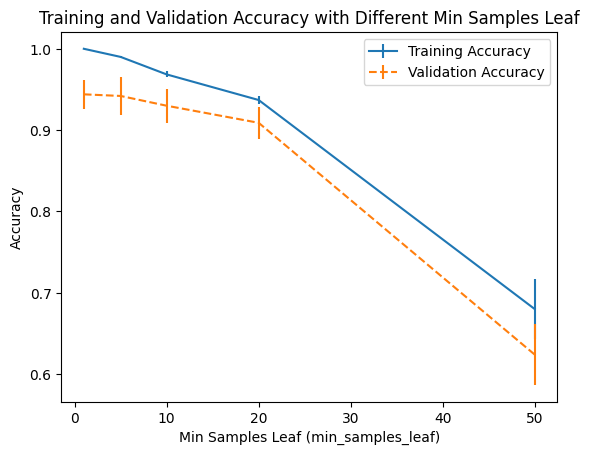

In [97]:
# Draw a line figure showing the training and validation result
plt.errorbar(results_min_samples_leaf_df['min_samples_leaf'], results_min_samples_leaf_df['avg_training_accuracy'], yerr=results_min_samples_leaf_df['training_std'], label='Training Accuracy')
plt.errorbar(results_min_samples_leaf_df['min_samples_leaf'], results_min_samples_leaf_df['avg_validation_accuracy'], yerr=results_min_samples_leaf_df['validation_std'], label='Validation Accuracy', linestyle='--')
plt.xlabel('Min Samples Leaf (min_samples_leaf)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy with Different Min Samples Leaf')
plt.legend()
plt.show()

# Section 4

In [98]:


# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(train_data['Processed_Text'])
X_test = vectorizer.transform(test_data['Processed_Text'])

# Split the data into features and target
y = train_data['Category']

# Model training and hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 150, 200],
    'min_samples_leaf': [3, 5, 7]
}
rf_model = RandomForestClassifier()
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X, y)

# Retrieve the best model and its parameters
best_rf_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Model evaluation using cross-validation
cv_results = cross_validate(best_rf_model, X, y, cv=5, return_train_score=True)
avg_train_accuracy = np.mean(cv_results['train_score'])
avg_val_accuracy = np.mean(cv_results['test_score'])
cv_accuracy = cross_val_score(best_rf_model, X, train_data['Category'], cv=5, scoring='accuracy')
# Predict labels for the test data
test_predictions = best_rf_model.predict(X_test)

# Create a DataFrame for the predictions in the specified format
predictions_df = pd.DataFrame({'ArticleId': test_data['ArticleId'], 'Category': test_predictions})
predictions_df['ArticleId_Category'] = predictions_df['ArticleId'].astype(str) + ',' + predictions_df['Category']
print("Best Model Parameters:", best_params)
print("Cross-Validation Accuracy:", cv_accuracy.mean())
print("Validation Set Accuracy:", avg_val_accuracy)

# Write the predictions to a CSV file in the specified format
predictions_file_path = '/content/drive/My Drive/Colab Notebooks/labels.csv'
with open(predictions_file_path, 'w') as file:
    for index, row in predictions_df.iterrows():
        file.write(f"{row['ArticleId']},{row['Category']}\n")
print(predictions_df)

Best Model Parameters: {'min_samples_leaf': 3, 'n_estimators': 100}
Cross-Validation Accuracy: 0.9470000000000001
Validation Set Accuracy: 0.945
     ArticleId       Category ArticleId_Category
0         1018          sport         1018,sport
1         1319           tech          1319,tech
2         1138          sport         1138,sport
3          459       business       459,business
4         1020          sport         1020,sport
..         ...            ...                ...
730       1923       business      1923,business
731        373  entertainment  373,entertainment
732       1704       politics      1704,politics
733        206       business       206,business
734        471       politics       471,politics

[735 rows x 3 columns]
